<a href="https://colab.research.google.com/github/gsanc018/Forecasting/blob/main/3_41_Price_%2B_Onchain_LR_Trees_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Download Data
!pip install keras_tuner -q

# import cryptocompare as cc
import requests
import IPython
import yaml
import json
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

# alternatively if you have not stored your API key in a separate file
api_key = 'b234d4305f5d1c5b9bb158e2cbb35da6703d86dd76e6d5c2f4b2fe4655ab3104'

# Number of past days for which we retrieve data
data_limit = 2000

# Define coin symbols
symbol_a = 'BTC'
symbol_b = 'ETH'

# Query price data

# Generic function for an API call to a given URL
def api_call(url):
  # Set API Key as Header
  headers = {'authorization': 'Apikey ' + api_key,}
  session = requests.Session()
  session.headers.update(headers)

  # API call to cryptocompare
  response = session.get(url)

  # Conversion of the response to dataframe
  historic_blockdata_dict = json.loads(response.text)
  df = pd.DataFrame.from_dict(historic_blockdata_dict.get('Data').get('Data'), orient='columns', dtype=None, columns=None)
  return df

def prepare_pricedata(df):
  df['date'] = pd.to_datetime(df['time'], unit='s')
  df.drop(columns=['time', 'conversionType', 'conversionSymbol'], inplace=True)
  return df

# Load the price data
base_url = 'https://min-api.cryptocompare.com/data/v2/histoday?fsym='


C=prepare_pricedata(api_call(f'{base_url}{symbol_a}&tsym=USD&limit={data_limit}&toTs={1678838400}'))
B=prepare_pricedata(api_call(f'{base_url}{symbol_a}&tsym=USD&limit={data_limit}&toTs={1506038400}'))
A=prepare_pricedata(api_call(f'{base_url}{symbol_a}&tsym=USD&limit={data_limit}&toTs={1333238400}'))

price_data = pd.concat([A[:-1],B[:-1],C]).reset_index(drop = True)
df = pd.DataFrame(price_data.close)
# get the index of the first non-null row
first_nonzero_row = df.index[df.apply(lambda x: x.ne(0)).any(1)][0]

price_data = price_data.set_index('date')[first_nonzero_row:]
# print(price_data)




# Prepare the onchain dataframe
def prepare_onchain_data(df):
  # replace the timestamp with a data and filter some faulty values
  df['date'] = pd.to_datetime(df['time'], unit='s')
  df.drop(columns='time', inplace=True)
  df = df[df['hashrate'] > 0.0]
  return df

# Load onchain data for Bitcoin
base_url = 'https://min-api.cryptocompare.com/data/blockchain/histo/day?fsym='

C = prepare_onchain_data(api_call(f'{base_url}{symbol_a}&limit={data_limit}&toTs={1678838400}'))
B = prepare_onchain_data(api_call(f'{base_url}{symbol_a}&limit={data_limit}&toTs={1506038400}'))
A = prepare_onchain_data(api_call(f'{base_url}{symbol_a}&limit={data_limit}&toTs={1333238400}'))

on_chain_data = pd.concat([A[:-1],B[:-1],C]).reset_index(drop = True)
on_chain_data = on_chain_data.iloc[:,2:].set_index('date')
# print(on_chain_data)


data = price_data[['close','volumefrom']].join(on_chain_data).dropna()
print(data.shape)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 4.2 MB/s eta 0:00:00


<ipython-input-1-1e6e6754ae79>:57: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  first_nonzero_row = df.index[df.apply(lambda x: x.ne(0)).any(1)][0]


(4621, 16)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


# Scale the data using MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Find the index of the 'close' column in scaled_data
price_index = data.columns.get_loc('close')

# Split data
train_size = int(len(scaled_data) * 0.85)
train_data = scaled_data[:train_size, :]
test_data = scaled_data[train_size:, :]

# Define window size
window_size = 30

# Prepare data for LSTM model
def prepare_data(data, window_size, target_index):
    X, Y = [], []
    for i in range(len(data)-window_size-1):
        X.append(data[i:(i+window_size), :])
        Y.append(data[i + window_size, target_index])
    return np.array(X), np.array(Y)

# Prepare data for the model
train_X, train_Y = prepare_data(train_data, window_size, price_index)
test_X, test_Y = prepare_data(test_data, window_size, price_index)
print(train_size)
print(train_X.shape, test_X.shape)
print(train_Y.shape, test_Y.shape)

actual_prices = data['close'].values[train_size + window_size:]


3927
(3896, 30, 16) (663, 30, 16)
(3896,) (663,)


In [ ]:
# Reshape the data to 2D for Linear Regression
train_X = train_X.reshape(train_X.shape[0], -1)
test_X = test_X.reshape(test_X.shape[0], -1)

print( train_X.shape, test_X.shape)


(3896, 480) (663, 480)


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error

# Function to test and plot the results for each model
def test_and_plot(model, model_name):
    # Make predictions
    test_predict = model.predict(test_X)
    # inv_test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
    # inv_test_Y = scaler.inverse_transform(test_Y.reshape(-1, 1))

    # Unscale the predicted values
    min_value = scaler.data_min_[price_index]
    max_value = scaler.data_max_[price_index]
    inv_test_predict = test_predict * (max_value - min_value) + min_value
    inv_test_Y = test_Y * (max_value - min_value) + min_value


    # Calculate evaluation metrics
    rmse = np.sqrt(mean_squared_error(inv_test_Y, inv_test_predict))
    mae = mean_absolute_error(inv_test_Y, inv_test_predict)
    msle = mean_squared_log_error(inv_test_Y, inv_test_predict)

    print(f"{model_name} Evaluation Metrics:")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"MSLE: {msle}")


    # Plot the predictions
    plt.figure(figsize=(10, 4))
    plt.plot(inv_test_predict, label="Predicted Price", color='red')
    plt.plot(inv_test_Y, label="Actual Price", color='green')

    plt.title(f'Bitcoin price prediction using {model_name}')
    plt.xlabel('Time [days]')
    plt.ylabel('Price')
    plt.legend(loc='best')

    plt.show()

# Linear Regression

In [ ]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# Create a TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=5)

Lasso

Best Lasso Parameters: {'alpha': 1e-05}
Best Lasso Score: -0.00042271615691623284
Lasso with GridSearch Evaluation Metrics:
RMSE: 1373.8779761246005
MAE: 928.7977585679621
MSLE: 0.0013997261662887217


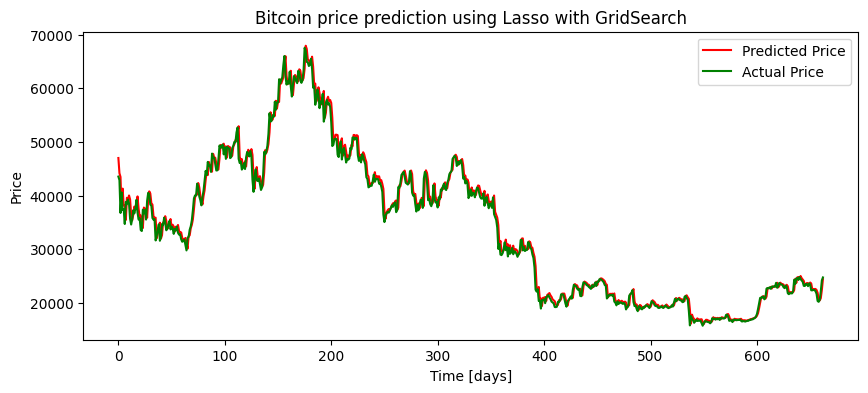

In [ ]:
# Define the parameter grid
param_grid = {
    'alpha': [0.00001, 0.0001 ,0.001 ,0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0],
}

# Create a GridSearchCV object
# grid_search_lasso = GridSearchCV(Lasso(), param_grid, cv=tscv, scoring='neg_mean_squared_error')
# Create a GridSearchCV object with max_iter = 5000 for Lasso
grid_search_lasso = GridSearchCV(Lasso(max_iter=5000), param_grid, cv=tscv, scoring='neg_mean_squared_error')

# Perform the grid search
grid_search_lasso.fit(train_X, train_Y)

# Print the best parameters and the best score
print('Best Lasso Parameters:', grid_search_lasso.best_params_)
print('Best Lasso Score:', grid_search_lasso.best_score_)

# Get the best model
best_lasso_model = grid_search_lasso.best_estimator_

# Test and plot with the best Lasso model
test_and_plot(best_lasso_model, 'Lasso with GridSearch')

Ridge

Best Ridge Parameters: {'alpha': 1e-05}
Best Ridge Score: -0.00010014757341673392
Ridge with GridSearch Evaluation Metrics:
RMSE: 1659.3141622169092
MAE: 1189.4598776817973
MSLE: 0.002293863222907447


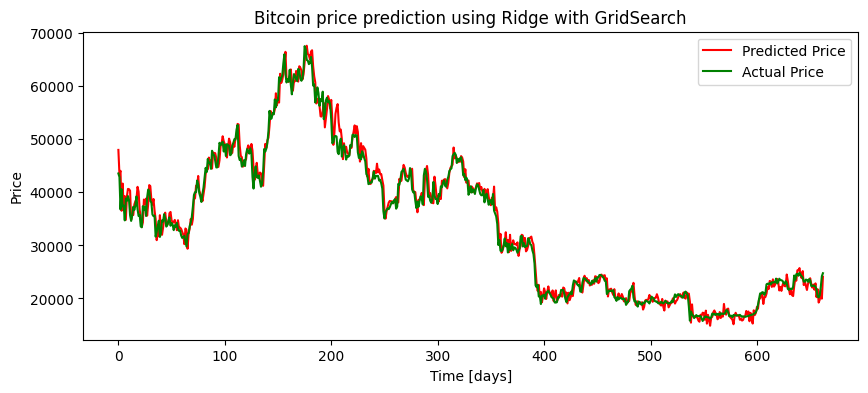

In [ ]:
# Define the parameter grid
param_grid = {
   'alpha': [0.00001, 0.0001 ,0.001 ,0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0],
}

# Create a GridSearchCV object
grid_search_ridge = GridSearchCV(Ridge(), param_grid, cv=tscv, scoring='neg_mean_squared_error')

# Perform the grid search
grid_search_ridge.fit(train_X, train_Y)

# Print the best parameters and the best score
print('Best Ridge Parameters:', grid_search_ridge.best_params_)
print('Best Ridge Score:', grid_search_ridge.best_score_)

# Get the best model
best_ridge_model = grid_search_ridge.best_estimator_

# Test and plot with the best Ridge model
test_and_plot(best_ridge_model, 'Ridge with GridSearch')

Elastic Net

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.804e-05, tolerance: 2.384e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.027e-04, tolerance: 2.980e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.134e-04, tolerance: 2.980e

Best Parameters: {'alpha': 1e-05, 'l1_ratio': 0.1}
Best Score: -0.00017621240334944694
ElasticNet with GridSearch Evaluation Metrics:
RMSE: 1590.8679719166762
MAE: 1160.4033293226546
MSLE: 0.002168908578768323


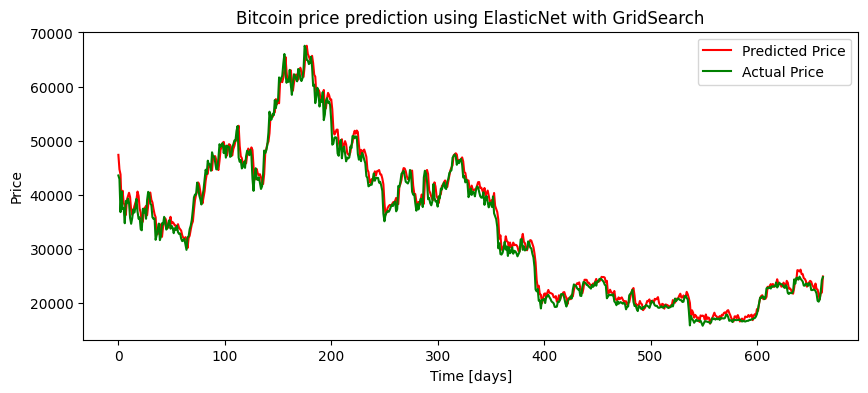

In [ ]:
# Define the parameter grid
param_grid = {
   'alpha': [0.00001, 0.0001 ,0.001 ,0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 1.0]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(ElasticNet(max_iter=10000), param_grid, cv=tscv, scoring='neg_mean_squared_error')

# Perform the grid search
grid_search.fit(train_X, train_Y)

# Print the best parameters and the best score
print('Best Parameters:', grid_search.best_params_)
print('Best Score:', grid_search.best_score_)

# Get the best model
best_elastic_model = grid_search.best_estimator_

# Test and plot with the best ElasticNet model
test_and_plot(best_elastic_model, 'ElasticNet with GridSearch')

# Tree Models

Random Forest


Best Random Forest Parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 30}
Best Random Forest Score: -0.009229142939247153
Random Forest with Random Search Evaluation Metrics:
RMSE: 12823.383200132801
MAE: 11251.144429385486
MSLE: 0.1615540634892282


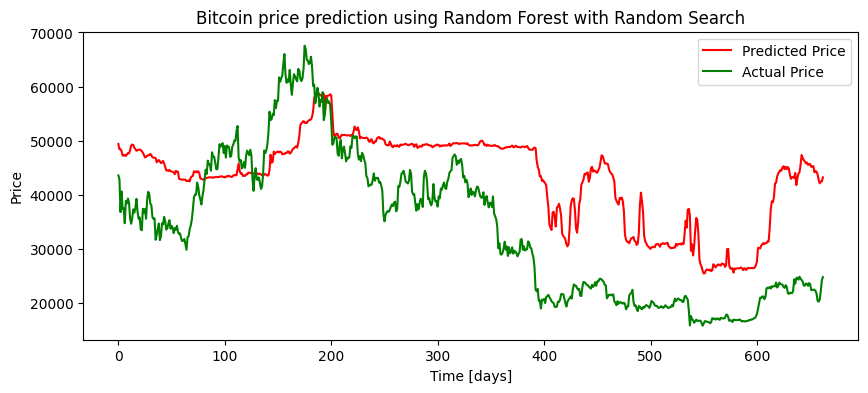

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define the parameter grid
param_distributions = {
    'n_estimators': [100, 200, 300, 500],  # Number of trees in random forest
    'max_depth': [10, 20, 30, None],  # Maximum number of levels in tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required at each leaf node
}

# Create a Random Forest Regressor object
rf = RandomForestRegressor(random_state=42)

# Create a RandomizedSearchCV object
random_search_rf = RandomizedSearchCV(rf, param_distributions, n_iter=1, cv=tscv, scoring='neg_mean_squared_error', random_state=42)

# Perform the random search
random_search_rf.fit(train_X, train_Y)

# Print the best parameters and the best score
print('Best Random Forest Parameters:', random_search_rf.best_params_)
print('Best Random Forest Score:', random_search_rf.best_score_)

# Get the best model
best_rf_model = random_search_rf.best_estimator_

test_and_plot(best_rf_model, 'Random Forest with Random Search')

Best Random Forest Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
Best Random Forest Score: -0.009135432790335445
Random Forest with Random Search Evaluation Metrics:
RMSE: 14030.777713729834
MAE: 12273.698215535444
MSLE: 0.1898993629852513


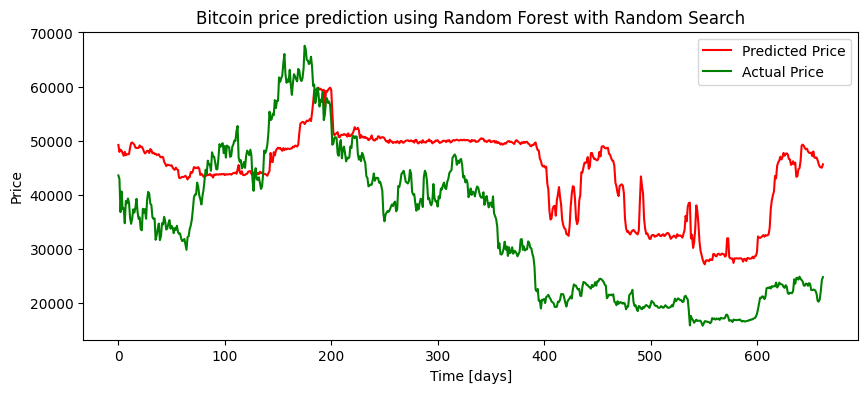

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define the parameter grid
param_distributions = {
    'n_estimators': [100, 200],  # Number of trees in random forest
    'max_depth': [10, None],  # Maximum number of levels in tree
    'min_samples_split': [2, 5],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2]  # Minimum number of samples required at each leaf node
}

# Create a Random Forest Regressor object
rf = RandomForestRegressor(random_state=42)

# Create a RandomizedSearchCV object
random_search_rf = RandomizedSearchCV(rf, param_distributions, n_iter=10, cv=tscv, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)

# Perform the random search
random_search_rf.fit(train_X, train_Y)

# Print the best parameters and the best score
print('Best Random Forest Parameters:', random_search_rf.best_params_)
print('Best Random Forest Score:', random_search_rf.best_score_)

# Get the best model
best_rf_model = random_search_rf.best_estimator_

test_and_plot(best_rf_model, 'Random Forest with Random Search')


Best XGBoost Parameters: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
Best XGBoost Score: -0.008089967006920131
XGBoost with Random Search Evaluation Metrics:
RMSE: 17222.445982111887
MAE: 14734.77120192308
MSLE: 0.2953192138676037


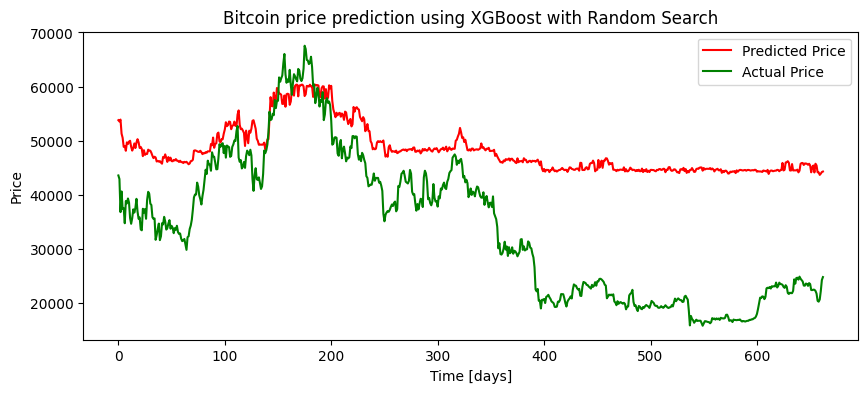

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
param_distributions = {
    'n_estimators': [100, 200, 300, 500],  # Number of trees
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Step size shrinkage used in update to prevents overfitting
    'max_depth': [3, 5, 7, 10],  # Maximum depth of a tree
    'subsample': [0.5, 0.7, 1.0],  # Subsample ratio of the training instances
    'colsample_bytree': [0.5, 0.7, 1.0]  # Subsample ratio of columns when constructing each tree
}

# Create a XGBRegressor object
xgb = XGBRegressor(random_state=42)

# Create a RandomizedSearchCV object
random_search_xgb = RandomizedSearchCV(xgb, param_distributions, n_iter=20, cv=tscv, scoring='neg_mean_squared_error', random_state=42)

# Perform the random search
random_search_xgb.fit(train_X, train_Y)

# Print the best parameters and the best score
print('Best XGBoost Parameters:', random_search_xgb.best_params_)
print('Best XGBoost Score:', random_search_xgb.best_score_)

# Get the best model
best_xgb_model = random_search_xgb.best_estimator_

test_and_plot(best_xgb_model, 'XGBoost with Random Search')

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error

# Function to test and plot the results for each model
def test(model, model_name):
    # Make predictions
    test_predict = model.predict(test_X)
    # inv_test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
    # inv_test_Y = scaler.inverse_transform(test_Y.reshape(-1, 1))

    # Unscale the predicted values
    min_value = scaler.data_min_[price_index]
    max_value = scaler.data_max_[price_index]
    inv_test_predict = test_predict * (max_value - min_value) + min_value
    inv_test_Y = test_Y * (max_value - min_value) + min_value


    # Calculate evaluation metrics
    rmse = np.sqrt(mean_squared_error(inv_test_Y, inv_test_predict))
    mae = mean_absolute_error(inv_test_Y, inv_test_predict)
    msle = mean_squared_log_error(inv_test_Y, inv_test_predict)

    print(f"{model_name} Evaluation Metrics:")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"MSLE: {msle}")
    print('\n')

In [ ]:
test(best_lasso_model, 'Lasso with GridSearch')
test(best_ridge_model, 'Ridge with GridSearch')
test(best_elastic_model, 'ElasticNet with GridSearch')
test(best_rf_model, 'RandomForest')
test(best_xgb_model, 'XGBoost')

Lasso with GridSearch Evaluation Metrics:
RMSE: 1373.8779761246005
MAE: 928.7977585679621
MSLE: 0.0013997261662887217


Ridge with GridSearch Evaluation Metrics:
RMSE: 1659.3141622169092
MAE: 1189.4598776817973
MSLE: 0.002293863222907447


ElasticNet with GridSearch Evaluation Metrics:
RMSE: 1590.8679719166762
MAE: 1160.4033293226546
MSLE: 0.002168908578768323


RandomForest Evaluation Metrics:
RMSE: 14030.777713729834
MAE: 12273.698215535444
MSLE: 0.1898993629852513


XGBoost Evaluation Metrics:
RMSE: 17222.445982111887
MAE: 14734.77120192308
MSLE: 0.2953192138676037


